In [13]:
import random
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model

## Misc

In [14]:
# todo: apply to classes
def make_trainable(net, val, lr=0.001):
    net.model.trainable = val
    for l in net.model.layers:
        l.trainable = val
    net.cmpile(lr)
    
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # при замене оптимизатора всё слетает ???
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def fit_discriminator(discriminator, Data, epochs, lr=0.001):
    make_trainable(discriminator, True, lr=lr)
    #discriminator.trainable = True
    discriminator.fit(Data.x, Data.y, epochs=epochs, plot=True)
    
# Training GAN
def fit_gan(gan, Data, epochs):
    p = Plot('GAN_results')

    for i in range(epochs):
        V = Data.load_random(n_samples=64)
        print("Epoch %d" % i)
        generated = generator.predict(V)
        if i % 10 == 0:
            p.add_to_gif(generated, np.ones(V.shape[0]), title='Epoch %d' % i, alpha=1)
        #make_trainable(discriminator, False)
        print("Fitting GAN")
        gan.fit(V, np.ones(V.shape[0]), epochs=2)
        #make_trainable(discriminator, True)
        print("Fitting discriminator")
        discriminator.fit(generated, np.zeros(V.shape[0]), validation_split=None)
        discriminator.fit(Data.x, Data.y, validation_split=0.2)
    p.save_gif()
    gan.save('gan.h5')


## Data generation class

In [15]:
# To generate data
class Dataset():
    x = None
    y = None
    W = None
    
    def __init__(self):
        return
    
    def load_data(self, data_range=10):
        dots_x = []
        for i in range(data_range*20):
            x = random.uniform(-data_range, data_range)
            dots_x.append((x, x**2)) # square
            for j in range(5):
                dots_x.append((x, random.uniform(-data_range, data_range**2))) # less than square
                #dots_x.append((x**r, x**(2*r*(1+random.gauss(0.5, 0.25)/20)))) # more than square
        dots_x = np.array(dots_x)
        #dots_y = np.array([random.uniform(0.75, 1.2) if x[0]**2 == x[1] else random.uniform(0, 0.3) for x in dots_x])
        dots_y = np.array([1 if x[0]**2 == x[1] else 0 for x in dots_x])
        self.x, self.y = dots_x, dots_y
        return dots_x, dots_y
    
    def load_weights(self, default_weight=0.12):
        W = self.y.copy().astype(float)
        W[W == 0] = 0.12
        self.W = W
        return W
        
    @staticmethod
    def load_random(n_dim=5, n_samples=16):
        V = np.random.normal(size=(n_samples, n_dim))
        return V
    

## Image plotting class

In [16]:
# To plot images
class Plot:
    name = ""
    images = []
    threshold = 0.0
    
    def __init__(self, name, threshold=0.6):
        self.name = name
        self.threshold = threshold
        self.images = []
    
    @staticmethod
    def parabola_plot(ax, xrange):
        x = np.linspace(xrange, 1)
        y = x*x
        plt.plot(x, y)
    
    @staticmethod
    def dots_plot(ax, dots_x, dots_y, color):
        ax.scatter(dots_x, dots_y, color=color, alpha=0.15)
        plt.plot()
    
    def picture(self, dots, predictions, title='', alpha=0.3):
        predictions = predictions.reshape(predictions.shape[0])
        dots_x = dots.T[0]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set(title=title)
        #ax2 = ax1.twinx()
        plt.grid(axis='both')
        xrange = (dots_x.min(), dots_x.max())
        self.parabola_plot(ax1, xrange)
        ax1.scatter(dots.T[0], dots.T[1], c=predictions, cmap='YlOrRd', alpha=alpha)
        
    def add_to_gif(self, dots_x, predictions, title='', alpha=0.3):
        self.picture(dots_x, predictions, title=title, alpha=alpha)
        plt.savefig(self.name+'.png')
        plt.close()
        image = Image.open(self.name+'.png')
        ar = np.asarray(image)
        self.images.append(ar)
        
    def save_gif(self):
        kargs = { 'duration': 0.2 }
        imageio.mimsave(self.name+'.gif', self.images, None, **kargs)
        

## Neural networks classes

In [17]:
# Classes for neural networks

# Generator
class Gen:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=5),
                            Dense(2, activation='linear')
        ])
        self.model = model
        
    def predict(self, dots_x):
        return self.model.predict(dots_x)
    
    def cmpile(self):
        return
    
# Discriminator
class Dsc:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=2),
                            Dense(1, activation='sigmoid')
        ])
        self.model = model
    
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
        
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=10, 
                               sample_weight=weights,
                               validation_split=validation_split)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        

# # Raw classes, don't work 

```python
class Gan:
    gen = None
    dsc = None
    model = None
    
    def __init__(self, gen, dsc, n_dim=5):
        make_trainable(dsc, False)
        self.gen = gen
        self.dsc = dsc
        # connect them
        model = Sequential()
        # add generator
        model.add(gen.model)
        # add the discriminator
        model.add(dsc.model)
        self.model = model
    
    # This method doesn't work
    # Presumably because of some optimizer issue
    def cmpile(self, lr=0.001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics = ['accuracy'])
        
    def fit(self, dots_x, dots_y, epochs=1):
        self.model.fit(dots_x, dots_y, epochs=epochs)
        
class Dummy:
    model = None
    
    def __init__(self, model):
        self.model = model
        
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
    
    # todo: remove hardcode
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs//25):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=25, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i*25)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
```

In [18]:
#discriminator = tf.keras.models.load_model('discriminator.h5')

# Start Here

In [27]:
# Generating data
Data = Dataset()
Data.load_data(data_range=15)
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()


In [28]:
fit_discriminator(discriminator, Data, 150, lr=0.0005)

Epoch 0 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 1s 585us/sample - loss: 6.8988 - acc: 0.8333 - val_loss: 7.3352 - val_acc: 0.8333
Epoch 2/10
1530/1530 [==============================] - 0s 192us/sample - loss: 5.4740 - acc: 0.8340 - val_loss: 5.7021 - val_acc: 0.8370
Epoch 3/10
1530/1530 [==============================] - 0s 264us/sample - loss: 4.1377 - acc: 0.8359 - val_loss: 4.1934 - val_acc: 0.8370
Epoch 4/10
1530/1530 [==============================] - 0s 232us/sample - loss: 2.8823 - acc: 0.8373 - val_loss: 2.6874 - val_acc: 0.8519
Epoch 5/10
1530/1530 [==============================] - 0s 180us/sample - loss: 1.7501 - acc: 0.8229 - val_loss: 1.5668 - val_acc: 0.8037
Epoch 6/10
1530/1530 [==============================] - 0s 212us/sample - loss: 1.0824 - acc: 0.7974 - val_loss: 1.1141 - val_acc: 0.7667
Epoch 7/10
1530/1530 [==============================] - 0s 198us/sample - loss: 0.8262 - acc: 0.7961 - val

1530/1530 [==============================] - 0s 184us/sample - loss: 0.3032 - acc: 0.8529 - val_loss: 0.3155 - val_acc: 0.8407
Epoch 8/10
1530/1530 [==============================] - 0s 169us/sample - loss: 0.3023 - acc: 0.8556 - val_loss: 0.3158 - val_acc: 0.8407
Epoch 9/10
1530/1530 [==============================] - 0s 168us/sample - loss: 0.3004 - acc: 0.8536 - val_loss: 0.3284 - val_acc: 0.8259
Epoch 10/10
1530/1530 [==============================] - 0s 196us/sample - loss: 0.3071 - acc: 0.8556 - val_loss: 0.3146 - val_acc: 0.8444
Epoch 6 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 168us/sample - loss: 0.3018 - acc: 0.8549 - val_loss: 0.3145 - val_acc: 0.8481
Epoch 2/10
1530/1530 [==============================] - 0s 175us/sample - loss: 0.3025 - acc: 0.8562 - val_loss: 0.3206 - val_acc: 0.8519
Epoch 3/10
1530/1530 [==============================] - 0s 166us/sample - loss: 0.3004 - acc: 0.8536 - val_loss: 0.3

1530/1530 [==============================] - 0s 171us/sample - loss: 0.2821 - acc: 0.8680 - val_loss: 0.2981 - val_acc: 0.8593
Epoch 4/10
1530/1530 [==============================] - 0s 217us/sample - loss: 0.2825 - acc: 0.8686 - val_loss: 0.2967 - val_acc: 0.8556
Epoch 5/10
1530/1530 [==============================] - 0s 175us/sample - loss: 0.2837 - acc: 0.8693 - val_loss: 0.2967 - val_acc: 0.8630
Epoch 6/10
1530/1530 [==============================] - 0s 175us/sample - loss: 0.2831 - acc: 0.8699 - val_loss: 0.3072 - val_acc: 0.8630
Epoch 7/10
1530/1530 [==============================] - 0s 174us/sample - loss: 0.2798 - acc: 0.8660 - val_loss: 0.3074 - val_acc: 0.8630
Epoch 8/10
1530/1530 [==============================] - 0s 169us/sample - loss: 0.2841 - acc: 0.8660 - val_loss: 0.3053 - val_acc: 0.8333
Epoch 9/10
1530/1530 [==============================] - 0s 181us/sample - loss: 0.2823 - acc: 0.8686 - val_loss: 0.3060 - val_acc: 0.8630
Epoch 10/10
1530/1530 [======================

Epoch 10/10
1530/1530 [==============================] - 0s 201us/sample - loss: 0.2719 - acc: 0.8680 - val_loss: 0.2975 - val_acc: 0.8667
Epoch 17 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 173us/sample - loss: 0.2702 - acc: 0.8693 - val_loss: 0.2867 - val_acc: 0.8593
Epoch 2/10
1530/1530 [==============================] - 0s 199us/sample - loss: 0.2710 - acc: 0.8627 - val_loss: 0.3012 - val_acc: 0.8667
Epoch 3/10
1530/1530 [==============================] - 0s 180us/sample - loss: 0.2715 - acc: 0.8712 - val_loss: 0.2873 - val_acc: 0.8593
Epoch 4/10
1530/1530 [==============================] - 0s 229us/sample - loss: 0.2697 - acc: 0.8699 - val_loss: 0.2850 - val_acc: 0.8519
Epoch 5/10
1530/1530 [==============================] - 0s 214us/sample - loss: 0.2699 - acc: 0.8660 - val_loss: 0.2889 - val_acc: 0.8593
Epoch 6/10
1530/1530 [==============================] - 0s 231us/sample - loss: 0.2705 - acc: 0.8725 - v

1530/1530 [==============================] - 0s 223us/sample - loss: 0.2608 - acc: 0.8706 - val_loss: 0.2801 - val_acc: 0.8556
Epoch 7/10
1530/1530 [==============================] - 0s 220us/sample - loss: 0.2612 - acc: 0.8706 - val_loss: 0.2827 - val_acc: 0.8481
Epoch 8/10
1530/1530 [==============================] - 0s 198us/sample - loss: 0.2628 - acc: 0.8719 - val_loss: 0.2745 - val_acc: 0.8556
Epoch 9/10
1530/1530 [==============================] - 0s 203us/sample - loss: 0.2610 - acc: 0.8680 - val_loss: 0.2745 - val_acc: 0.8630
Epoch 10/10
1530/1530 [==============================] - 0s 176us/sample - loss: 0.2625 - acc: 0.8752 - val_loss: 0.2742 - val_acc: 0.8593
Epoch 23 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 162us/sample - loss: 0.2627 - acc: 0.8673 - val_loss: 0.2990 - val_acc: 0.8741
Epoch 2/10
1530/1530 [==============================] - 0s 175us/sample - loss: 0.2641 - acc: 0.8752 - val_loss: 0.

1530/1530 [==============================] - 0s 203us/sample - loss: 0.2536 - acc: 0.8725 - val_loss: 0.2615 - val_acc: 0.8667
Epoch 3/10
1530/1530 [==============================] - 0s 177us/sample - loss: 0.2529 - acc: 0.8804 - val_loss: 0.2618 - val_acc: 0.8593
Epoch 4/10
1530/1530 [==============================] - 0s 223us/sample - loss: 0.2505 - acc: 0.8791 - val_loss: 0.2617 - val_acc: 0.8667
Epoch 5/10
1530/1530 [==============================] - 0s 177us/sample - loss: 0.2508 - acc: 0.8732 - val_loss: 0.2612 - val_acc: 0.8667
Epoch 6/10
1530/1530 [==============================] - 0s 177us/sample - loss: 0.2455 - acc: 0.8739 - val_loss: 0.2623 - val_acc: 0.8630
Epoch 7/10
1530/1530 [==============================] - 0s 168us/sample - loss: 0.2497 - acc: 0.8765 - val_loss: 0.2624 - val_acc: 0.8630
Epoch 8/10
1530/1530 [==============================] - 0s 165us/sample - loss: 0.2475 - acc: 0.8791 - val_loss: 0.2596 - val_acc: 0.8630
Epoch 9/10
1530/1530 [=======================

Epoch 9/10
1530/1530 [==============================] - 0s 192us/sample - loss: 0.2384 - acc: 0.8824 - val_loss: 0.2465 - val_acc: 0.8667
Epoch 10/10
1530/1530 [==============================] - 0s 170us/sample - loss: 0.2403 - acc: 0.8771 - val_loss: 0.2484 - val_acc: 0.8667
Epoch 34 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 197us/sample - loss: 0.2341 - acc: 0.8824 - val_loss: 0.2477 - val_acc: 0.8741
Epoch 2/10
1530/1530 [==============================] - 0s 204us/sample - loss: 0.2411 - acc: 0.8784 - val_loss: 0.2475 - val_acc: 0.8741
Epoch 3/10
1530/1530 [==============================] - 0s 226us/sample - loss: 0.2332 - acc: 0.8817 - val_loss: 0.2490 - val_acc: 0.8741
Epoch 4/10
1530/1530 [==============================] - 0s 226us/sample - loss: 0.2344 - acc: 0.8810 - val_loss: 0.2471 - val_acc: 0.8704
Epoch 5/10
1530/1530 [==============================] - 0s 190us/sample - loss: 0.2347 - acc: 0.8791 - v

1530/1530 [==============================] - 0s 206us/sample - loss: 0.2343 - acc: 0.8810 - val_loss: 0.2409 - val_acc: 0.8741
Epoch 6/10
1530/1530 [==============================] - 0s 214us/sample - loss: 0.2242 - acc: 0.8850 - val_loss: 0.2399 - val_acc: 0.8815
Epoch 7/10
1530/1530 [==============================] - 0s 182us/sample - loss: 0.2250 - acc: 0.8837 - val_loss: 0.2358 - val_acc: 0.8704
Epoch 8/10
1530/1530 [==============================] - 0s 213us/sample - loss: 0.2232 - acc: 0.8817 - val_loss: 0.2388 - val_acc: 0.8704
Epoch 9/10
1530/1530 [==============================] - 0s 187us/sample - loss: 0.2295 - acc: 0.8837 - val_loss: 0.2365 - val_acc: 0.8704
Epoch 10/10
1530/1530 [==============================] - 0s 192us/sample - loss: 0.2249 - acc: 0.8830 - val_loss: 0.2369 - val_acc: 0.8704
Epoch 40 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 181us/sample - loss: 0.2251 - acc: 0.8856 - val_loss: 0.

1530/1530 [==============================] - 0s 183us/sample - loss: 0.2170 - acc: 0.8856 - val_loss: 0.2286 - val_acc: 0.8704
Epoch 2/10
1530/1530 [==============================] - 0s 178us/sample - loss: 0.2156 - acc: 0.8902 - val_loss: 0.2300 - val_acc: 0.8778
Epoch 3/10
1530/1530 [==============================] - 0s 183us/sample - loss: 0.2166 - acc: 0.8856 - val_loss: 0.2312 - val_acc: 0.8704
Epoch 4/10
1530/1530 [==============================] - 0s 258us/sample - loss: 0.2176 - acc: 0.8908 - val_loss: 0.2281 - val_acc: 0.8778
Epoch 5/10
1530/1530 [==============================] - 0s 224us/sample - loss: 0.2157 - acc: 0.8824 - val_loss: 0.2480 - val_acc: 0.8926
Epoch 6/10
1530/1530 [==============================] - 0s 234us/sample - loss: 0.2218 - acc: 0.8824 - val_loss: 0.2443 - val_acc: 0.8963
Epoch 7/10
1530/1530 [==============================] - 0s 218us/sample - loss: 0.2194 - acc: 0.8902 - val_loss: 0.2372 - val_acc: 0.8741
Epoch 8/10
1530/1530 [=======================

Epoch 8/10
1530/1530 [==============================] - 0s 197us/sample - loss: 0.2057 - acc: 0.8902 - val_loss: 0.2199 - val_acc: 0.8889
Epoch 9/10
1530/1530 [==============================] - 0s 188us/sample - loss: 0.2079 - acc: 0.8902 - val_loss: 0.2186 - val_acc: 0.8741
Epoch 10/10
1530/1530 [==============================] - 0s 217us/sample - loss: 0.2066 - acc: 0.8889 - val_loss: 0.2190 - val_acc: 0.8741
Epoch 51 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 194us/sample - loss: 0.2059 - acc: 0.8948 - val_loss: 0.2163 - val_acc: 0.8741
Epoch 2/10
1530/1530 [==============================] - 0s 215us/sample - loss: 0.2041 - acc: 0.8882 - val_loss: 0.2303 - val_acc: 0.8815
Epoch 3/10
1530/1530 [==============================] - 0s 265us/sample - loss: 0.2056 - acc: 0.8869 - val_loss: 0.2199 - val_acc: 0.8778
Epoch 4/10
1530/1530 [==============================] - 0s 250us/sample - loss: 0.2042 - acc: 0.8908 - v

1530/1530 [==============================] - 0s 242us/sample - loss: 0.1960 - acc: 0.8974 - val_loss: 0.2255 - val_acc: 0.9148
Epoch 5/10
1530/1530 [==============================] - 0s 183us/sample - loss: 0.1955 - acc: 0.8908 - val_loss: 0.2134 - val_acc: 0.8778
Epoch 6/10
1530/1530 [==============================] - 0s 179us/sample - loss: 0.1977 - acc: 0.8902 - val_loss: 0.2118 - val_acc: 0.9037
Epoch 7/10
1530/1530 [==============================] - 0s 218us/sample - loss: 0.1935 - acc: 0.8941 - val_loss: 0.2093 - val_acc: 0.8778
Epoch 8/10
1530/1530 [==============================] - 0s 179us/sample - loss: 0.1980 - acc: 0.8915 - val_loss: 0.2102 - val_acc: 0.8741
Epoch 9/10
1530/1530 [==============================] - 0s 179us/sample - loss: 0.1987 - acc: 0.8967 - val_loss: 0.2294 - val_acc: 0.8852
Epoch 10/10
1530/1530 [==============================] - 0s 186us/sample - loss: 0.1990 - acc: 0.8935 - val_loss: 0.2089 - val_acc: 0.8852
Epoch 57 out of 150
Train on 1530 samples, v

1530/1530 [==============================] - 0s 279us/sample - loss: 0.1884 - acc: 0.9026 - val_loss: 0.2041 - val_acc: 0.8778
Epoch 62 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 224us/sample - loss: 0.1834 - acc: 0.9039 - val_loss: 0.1973 - val_acc: 0.8852
Epoch 2/10
1530/1530 [==============================] - 0s 237us/sample - loss: 0.1858 - acc: 0.8974 - val_loss: 0.2009 - val_acc: 0.9185
Epoch 3/10
1530/1530 [==============================] - 0s 267us/sample - loss: 0.1854 - acc: 0.9092 - val_loss: 0.1966 - val_acc: 0.9111
Epoch 4/10
1530/1530 [==============================] - 0s 241us/sample - loss: 0.1842 - acc: 0.9098 - val_loss: 0.2019 - val_acc: 0.8778
Epoch 5/10
1530/1530 [==============================] - 0s 280us/sample - loss: 0.1857 - acc: 0.8974 - val_loss: 0.1963 - val_acc: 0.8852
Epoch 6/10
1530/1530 [==============================] - 0s 253us/sample - loss: 0.1823 - acc: 0.9039 - val_loss: 0.1

1530/1530 [==============================] - 1s 343us/sample - loss: 0.1795 - acc: 0.9078 - val_loss: 0.1898 - val_acc: 0.9148
Epoch 7/10
1530/1530 [==============================] - 0s 253us/sample - loss: 0.1748 - acc: 0.9229 - val_loss: 0.1929 - val_acc: 0.8778
Epoch 8/10
1530/1530 [==============================] - 0s 208us/sample - loss: 0.1750 - acc: 0.9144 - val_loss: 0.2014 - val_acc: 0.8778
Epoch 9/10
1530/1530 [==============================] - 0s 211us/sample - loss: 0.1820 - acc: 0.9020 - val_loss: 0.1892 - val_acc: 0.9111
Epoch 10/10
1530/1530 [==============================] - 0s 179us/sample - loss: 0.1740 - acc: 0.9072 - val_loss: 0.1879 - val_acc: 0.9074
Epoch 68 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 202us/sample - loss: 0.1771 - acc: 0.9098 - val_loss: 0.1941 - val_acc: 0.8889
Epoch 2/10
1530/1530 [==============================] - 0s 182us/sample - loss: 0.1749 - acc: 0.9157 - val_loss: 0.

1530/1530 [==============================] - 0s 224us/sample - loss: 0.1699 - acc: 0.9157 - val_loss: 0.1829 - val_acc: 0.9148
Epoch 3/10
1530/1530 [==============================] - 0s 153us/sample - loss: 0.1689 - acc: 0.9150 - val_loss: 0.1867 - val_acc: 0.9296
Epoch 4/10
1530/1530 [==============================] - 0s 154us/sample - loss: 0.1696 - acc: 0.9242 - val_loss: 0.1854 - val_acc: 0.9222
Epoch 5/10
1530/1530 [==============================] - 0s 164us/sample - loss: 0.1686 - acc: 0.9190 - val_loss: 0.1855 - val_acc: 0.8963
Epoch 6/10
1530/1530 [==============================] - 0s 213us/sample - loss: 0.1688 - acc: 0.9216 - val_loss: 0.1854 - val_acc: 0.9037
Epoch 7/10
1530/1530 [==============================] - 0s 199us/sample - loss: 0.1664 - acc: 0.9255 - val_loss: 0.1835 - val_acc: 0.9074
Epoch 8/10
1530/1530 [==============================] - 0s 154us/sample - loss: 0.1673 - acc: 0.9216 - val_loss: 0.1853 - val_acc: 0.8926
Epoch 9/10
1530/1530 [=======================

Epoch 9/10
1530/1530 [==============================] - 0s 151us/sample - loss: 0.1683 - acc: 0.9248 - val_loss: 0.1871 - val_acc: 0.9259
Epoch 10/10
1530/1530 [==============================] - 0s 140us/sample - loss: 0.1638 - acc: 0.9190 - val_loss: 0.1814 - val_acc: 0.8889
Epoch 79 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1614 - acc: 0.9248 - val_loss: 0.1804 - val_acc: 0.9111
Epoch 2/10
1530/1530 [==============================] - 0s 134us/sample - loss: 0.1620 - acc: 0.9261 - val_loss: 0.1855 - val_acc: 0.9148
Epoch 3/10
1530/1530 [==============================] - 0s 145us/sample - loss: 0.1670 - acc: 0.9229 - val_loss: 0.1807 - val_acc: 0.9185
Epoch 4/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1633 - acc: 0.9235 - val_loss: 0.1818 - val_acc: 0.9111
Epoch 5/10
1530/1530 [==============================] - 0s 167us/sample - loss: 0.1632 - acc: 0.9320 - v

1530/1530 [==============================] - 0s 163us/sample - loss: 0.1572 - acc: 0.9294 - val_loss: 0.1789 - val_acc: 0.9222
Epoch 6/10
1530/1530 [==============================] - 0s 216us/sample - loss: 0.1554 - acc: 0.9346 - val_loss: 0.1978 - val_acc: 0.8852
Epoch 7/10
1530/1530 [==============================] - 0s 166us/sample - loss: 0.1587 - acc: 0.9275 - val_loss: 0.1838 - val_acc: 0.8852
Epoch 8/10
1530/1530 [==============================] - 0s 207us/sample - loss: 0.1628 - acc: 0.9294 - val_loss: 0.1838 - val_acc: 0.8889
Epoch 9/10
1530/1530 [==============================] - 0s 203us/sample - loss: 0.1605 - acc: 0.9242 - val_loss: 0.1869 - val_acc: 0.9222
Epoch 10/10
1530/1530 [==============================] - 1s 574us/sample - loss: 0.1618 - acc: 0.9248 - val_loss: 0.1778 - val_acc: 0.9037
Epoch 85 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 184us/sample - loss: 0.1591 - acc: 0.9333 - val_loss: 0.

1530/1530 [==============================] - 0s 224us/sample - loss: 0.1536 - acc: 0.9294 - val_loss: 0.1729 - val_acc: 0.9222
Epoch 2/10
1530/1530 [==============================] - 0s 177us/sample - loss: 0.1541 - acc: 0.9268 - val_loss: 0.1763 - val_acc: 0.9148
Epoch 3/10
1530/1530 [==============================] - 0s 198us/sample - loss: 0.1565 - acc: 0.9301 - val_loss: 0.1748 - val_acc: 0.9148
Epoch 4/10
1530/1530 [==============================] - 0s 234us/sample - loss: 0.1533 - acc: 0.9333 - val_loss: 0.1729 - val_acc: 0.9222
Epoch 5/10
1530/1530 [==============================] - 0s 184us/sample - loss: 0.1544 - acc: 0.9294 - val_loss: 0.1833 - val_acc: 0.9296
Epoch 6/10
1530/1530 [==============================] - 0s 191us/sample - loss: 0.1586 - acc: 0.9261 - val_loss: 0.1786 - val_acc: 0.8889
Epoch 7/10
1530/1530 [==============================] - 0s 188us/sample - loss: 0.1540 - acc: 0.9320 - val_loss: 0.1806 - val_acc: 0.8852
Epoch 8/10
1530/1530 [=======================

Epoch 8/10
1530/1530 [==============================] - 0s 144us/sample - loss: 0.1518 - acc: 0.9301 - val_loss: 0.1702 - val_acc: 0.9148
Epoch 9/10
1530/1530 [==============================] - 0s 158us/sample - loss: 0.1566 - acc: 0.9294 - val_loss: 0.1737 - val_acc: 0.9185
Epoch 10/10
1530/1530 [==============================] - 0s 168us/sample - loss: 0.1494 - acc: 0.9307 - val_loss: 0.1696 - val_acc: 0.9296
Epoch 96 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 150us/sample - loss: 0.1505 - acc: 0.9346 - val_loss: 0.1691 - val_acc: 0.9148
Epoch 2/10
1530/1530 [==============================] - 0s 200us/sample - loss: 0.1550 - acc: 0.9288 - val_loss: 0.1755 - val_acc: 0.9148
Epoch 3/10
1530/1530 [==============================] - 0s 143us/sample - loss: 0.1517 - acc: 0.9255 - val_loss: 0.1743 - val_acc: 0.9111
Epoch 4/10
1530/1530 [==============================] - 0s 172us/sample - loss: 0.1568 - acc: 0.9353 - v

Epoch 4/10
1530/1530 [==============================] - 0s 184us/sample - loss: 0.1478 - acc: 0.9307 - val_loss: 0.1678 - val_acc: 0.9333
Epoch 5/10
1530/1530 [==============================] - 0s 185us/sample - loss: 0.1461 - acc: 0.9392 - val_loss: 0.1731 - val_acc: 0.9185
Epoch 6/10
1530/1530 [==============================] - 0s 156us/sample - loss: 0.1505 - acc: 0.9353 - val_loss: 0.1785 - val_acc: 0.9148
Epoch 7/10
1530/1530 [==============================] - 0s 159us/sample - loss: 0.1489 - acc: 0.9314 - val_loss: 0.1738 - val_acc: 0.9185
Epoch 8/10
1530/1530 [==============================] - 0s 166us/sample - loss: 0.1515 - acc: 0.9294 - val_loss: 0.1698 - val_acc: 0.9407
Epoch 9/10
1530/1530 [==============================] - 0s 159us/sample - loss: 0.1515 - acc: 0.9301 - val_loss: 0.1738 - val_acc: 0.8889
Epoch 10/10
1530/1530 [==============================] - 0s 145us/sample - loss: 0.1541 - acc: 0.9288 - val_loss: 0.1996 - val_acc: 0.9111
Epoch 102 out of 150
Train on 153

Epoch 107 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1501 - acc: 0.9268 - val_loss: 0.1636 - val_acc: 0.9296
Epoch 2/10
1530/1530 [==============================] - 0s 140us/sample - loss: 0.1449 - acc: 0.9346 - val_loss: 0.1668 - val_acc: 0.9222
Epoch 3/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1458 - acc: 0.9359 - val_loss: 0.1653 - val_acc: 0.9519
Epoch 4/10
1530/1530 [==============================] - 0s 135us/sample - loss: 0.1472 - acc: 0.9346 - val_loss: 0.1715 - val_acc: 0.8926
Epoch 5/10
1530/1530 [==============================] - 0s 169us/sample - loss: 0.1454 - acc: 0.9333 - val_loss: 0.1751 - val_acc: 0.9148
Epoch 6/10
1530/1530 [==============================] - 0s 134us/sample - loss: 0.1420 - acc: 0.9425 - val_loss: 0.1970 - val_acc: 0.8926
Epoch 7/10
1530/1530 [==============================] - 0s 143us/sample - loss: 0.1568 - acc: 0.9261 - v

1530/1530 [==============================] - 0s 136us/sample - loss: 0.1426 - acc: 0.9346 - val_loss: 0.1696 - val_acc: 0.9259
Epoch 8/10
1530/1530 [==============================] - 0s 142us/sample - loss: 0.1447 - acc: 0.9359 - val_loss: 0.1635 - val_acc: 0.9370
Epoch 9/10
1530/1530 [==============================] - 0s 138us/sample - loss: 0.1461 - acc: 0.9327 - val_loss: 0.1680 - val_acc: 0.9222
Epoch 10/10
1530/1530 [==============================] - 0s 135us/sample - loss: 0.1426 - acc: 0.9359 - val_loss: 0.1730 - val_acc: 0.9370
Epoch 113 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 146us/sample - loss: 0.1498 - acc: 0.9346 - val_loss: 0.1686 - val_acc: 0.9148
Epoch 2/10
1530/1530 [==============================] - 0s 135us/sample - loss: 0.1473 - acc: 0.9320 - val_loss: 0.1666 - val_acc: 0.9222
Epoch 3/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1446 - acc: 0.9346 - val_loss: 0

1530/1530 [==============================] - 0s 162us/sample - loss: 0.1421 - acc: 0.9405 - val_loss: 0.1701 - val_acc: 0.8889
Epoch 4/10
1530/1530 [==============================] - 0s 194us/sample - loss: 0.1443 - acc: 0.9346 - val_loss: 0.1671 - val_acc: 0.9407
Epoch 5/10
1530/1530 [==============================] - 0s 152us/sample - loss: 0.1410 - acc: 0.9386 - val_loss: 0.1800 - val_acc: 0.9074
Epoch 6/10
1530/1530 [==============================] - 0s 134us/sample - loss: 0.1430 - acc: 0.9307 - val_loss: 0.1602 - val_acc: 0.9444
Epoch 7/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1410 - acc: 0.9346 - val_loss: 0.1777 - val_acc: 0.9370
Epoch 8/10
1530/1530 [==============================] - 0s 133us/sample - loss: 0.1470 - acc: 0.9281 - val_loss: 0.1621 - val_acc: 0.9259
Epoch 9/10
1530/1530 [==============================] - 0s 134us/sample - loss: 0.1470 - acc: 0.9353 - val_loss: 0.1714 - val_acc: 0.8889
Epoch 10/10
1530/1530 [======================

Epoch 10/10
1530/1530 [==============================] - 0s 186us/sample - loss: 0.1400 - acc: 0.9359 - val_loss: 0.1652 - val_acc: 0.9185
Epoch 124 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 134us/sample - loss: 0.1411 - acc: 0.9353 - val_loss: 0.1623 - val_acc: 0.9407
Epoch 2/10
1530/1530 [==============================] - 0s 142us/sample - loss: 0.1406 - acc: 0.9359 - val_loss: 0.1605 - val_acc: 0.9259
Epoch 3/10
1530/1530 [==============================] - 0s 153us/sample - loss: 0.1460 - acc: 0.9320 - val_loss: 0.1612 - val_acc: 0.9222
Epoch 4/10
1530/1530 [==============================] - 0s 173us/sample - loss: 0.1427 - acc: 0.9405 - val_loss: 0.1610 - val_acc: 0.9407
Epoch 5/10
1530/1530 [==============================] - 0s 185us/sample - loss: 0.1420 - acc: 0.9379 - val_loss: 0.1592 - val_acc: 0.9370
Epoch 6/10
1530/1530 [==============================] - 0s 197us/sample - loss: 0.1409 - acc: 0.9340 - 

1530/1530 [==============================] - 0s 166us/sample - loss: 0.1407 - acc: 0.9379 - val_loss: 0.1618 - val_acc: 0.9296
Epoch 7/10
1530/1530 [==============================] - 0s 154us/sample - loss: 0.1386 - acc: 0.9386 - val_loss: 0.1720 - val_acc: 0.9185
Epoch 8/10
1530/1530 [==============================] - 0s 176us/sample - loss: 0.1430 - acc: 0.9346 - val_loss: 0.1647 - val_acc: 0.9370
Epoch 9/10
1530/1530 [==============================] - 0s 178us/sample - loss: 0.1387 - acc: 0.9346 - val_loss: 0.1661 - val_acc: 0.9222
Epoch 10/10
1530/1530 [==============================] - 0s 163us/sample - loss: 0.1419 - acc: 0.9399 - val_loss: 0.1806 - val_acc: 0.9370
Epoch 130 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 207us/sample - loss: 0.1406 - acc: 0.9373 - val_loss: 0.1614 - val_acc: 0.9333
Epoch 2/10
1530/1530 [==============================] - 0s 194us/sample - loss: 0.1526 - acc: 0.9294 - val_loss: 0

1530/1530 [==============================] - 0s 173us/sample - loss: 0.1381 - acc: 0.9314 - val_loss: 0.1633 - val_acc: 0.9296
Epoch 3/10
1530/1530 [==============================] - 0s 165us/sample - loss: 0.1371 - acc: 0.9431 - val_loss: 0.1769 - val_acc: 0.9333
Epoch 4/10
1530/1530 [==============================] - 0s 147us/sample - loss: 0.1404 - acc: 0.9379 - val_loss: 0.1651 - val_acc: 0.9185
Epoch 5/10
1530/1530 [==============================] - 0s 145us/sample - loss: 0.1379 - acc: 0.9405 - val_loss: 0.1617 - val_acc: 0.9370
Epoch 6/10
1530/1530 [==============================] - 0s 138us/sample - loss: 0.1435 - acc: 0.9359 - val_loss: 0.1718 - val_acc: 0.9370
Epoch 7/10
1530/1530 [==============================] - 0s 138us/sample - loss: 0.1428 - acc: 0.9379 - val_loss: 0.1727 - val_acc: 0.9074
Epoch 8/10
1530/1530 [==============================] - 0s 148us/sample - loss: 0.1391 - acc: 0.9373 - val_loss: 0.1589 - val_acc: 0.9333
Epoch 9/10
1530/1530 [=======================

Epoch 9/10
1530/1530 [==============================] - 0s 136us/sample - loss: 0.1352 - acc: 0.9451 - val_loss: 0.1631 - val_acc: 0.9259
Epoch 10/10
1530/1530 [==============================] - 0s 140us/sample - loss: 0.1362 - acc: 0.9431 - val_loss: 0.1605 - val_acc: 0.9222
Epoch 141 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 168us/sample - loss: 0.1347 - acc: 0.9346 - val_loss: 0.1662 - val_acc: 0.9444
Epoch 2/10
1530/1530 [==============================] - 0s 146us/sample - loss: 0.1361 - acc: 0.9399 - val_loss: 0.1869 - val_acc: 0.9185
Epoch 3/10
1530/1530 [==============================] - 0s 152us/sample - loss: 0.1451 - acc: 0.9275 - val_loss: 0.1701 - val_acc: 0.9259
Epoch 4/10
1530/1530 [==============================] - 0s 171us/sample - loss: 0.1391 - acc: 0.9379 - val_loss: 0.1789 - val_acc: 0.8889
Epoch 5/10
1530/1530 [==============================] - 0s 153us/sample - loss: 0.1372 - acc: 0.9425 - 

Epoch 5/10
1530/1530 [==============================] - 0s 282us/sample - loss: 0.1363 - acc: 0.9418 - val_loss: 0.1630 - val_acc: 0.9407
Epoch 6/10
1530/1530 [==============================] - 0s 272us/sample - loss: 0.1360 - acc: 0.9353 - val_loss: 0.1617 - val_acc: 0.9370
Epoch 7/10
1530/1530 [==============================] - 1s 390us/sample - loss: 0.1371 - acc: 0.9366 - val_loss: 0.1637 - val_acc: 0.9074
Epoch 8/10
1530/1530 [==============================] - 1s 727us/sample - loss: 0.1379 - acc: 0.9333 - val_loss: 0.1718 - val_acc: 0.9333
Epoch 9/10
1530/1530 [==============================] - 1s 338us/sample - loss: 0.1360 - acc: 0.9399 - val_loss: 0.1767 - val_acc: 0.9074
Epoch 10/10
1530/1530 [==============================] - 0s 210us/sample - loss: 0.1447 - acc: 0.9301 - val_loss: 0.1703 - val_acc: 0.9259
Epoch 147 out of 150
Train on 1530 samples, validate on 270 samples
Epoch 1/10
1530/1530 [==============================] - 0s 234us/sample - loss: 0.1358 - acc: 0.9373 - 

In [35]:
TestData = Dataset()
TestData.load_data(data_range=15)
discriminator.model.evaluate(TestData.x, TestData.y)

1800/1800 [==============================] - 0s 99us/sample - loss: 0.1643 - acc: 0.9344


[0.16432734880182479, 0.9344444]

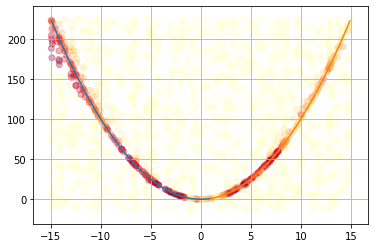

In [59]:
Plot('test2').picture(TestData.x, discriminator.model.predict(TestData.x))

In [37]:
NewData = Dataset()
NewData.load_data(data_range=15)

(array([[  6.25208647,  39.08858529],
        [  6.25208647,  -8.30056238],
        [  6.25208647,  53.16194665],
        ...,
        [  8.21697349,  75.31942414],
        [  8.21697349,  -8.30596556],
        [  8.21697349, -11.68603093]]), array([1, 0, 0, ..., 0, 0, 0]))

In [51]:
#gan = define_gan(generator.model, discriminator.model)
fit_gan(gan, NewData, 200)

Epoch 0
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.3295
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3120
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.5578 - acc: 0.7812
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 230us/sample - loss: 0.1279 - acc: 0.9384 - val_loss: 0.1726 - val_acc: 0.9306
Epoch 1
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.2143
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2142
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.6271 - acc: 0.8281
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 234us/sample - loss: 0.1272 - acc: 0.9444 - val_loss: 0.1715 - val_acc: 0.9306
Epoch 2
Fitting GAN
Epoch 1/2
64/64 [==============================]

64/64 [==============================] - 0s 218us/sample - loss: 1.0005 - acc: 0.6562
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 231us/sample - loss: 0.1235 - acc: 0.9470 - val_loss: 0.1738 - val_acc: 0.9306
Epoch 18
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.4724
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.4592
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.4880 - acc: 0.7969
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 226us/sample - loss: 0.1248 - acc: 0.9470 - val_loss: 0.1650 - val_acc: 0.9236
Epoch 19
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3930
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.3690
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0

Epoch 35
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2114
Epoch 2/2
64/64 [==============================] - 0s 156us/sample - loss: 1.2017
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.7589 - acc: 0.7031
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 197us/sample - loss: 0.1220 - acc: 0.9470 - val_loss: 0.1644 - val_acc: 0.9340
Epoch 36
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2825
Epoch 2/2
64/64 [==============================] - 0s 374us/sample - loss: 1.2783
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.6403 - acc: 0.7031
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 198us/sample - loss: 0.1218 - acc: 0.9470 - val_loss: 0.1618 - val_acc: 0.9306
Epoch 37
Fitting GAN
Epoch 1/2
64/64 [============================

64/64 [==============================] - 0s 265us/sample - loss: 0.6449 - acc: 0.7500
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 329us/sample - loss: 0.1245 - acc: 0.9453 - val_loss: 0.1577 - val_acc: 0.9375
Epoch 53
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.3371
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.3357
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.8078 - acc: 0.7500
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 255us/sample - loss: 0.1276 - acc: 0.9392 - val_loss: 0.1623 - val_acc: 0.9375
Epoch 54
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2651
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.2530
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0

Epoch 70
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.3258
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.3135
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.7095 - acc: 0.7969
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 198us/sample - loss: 0.1251 - acc: 0.9418 - val_loss: 0.1746 - val_acc: 0.9097
Epoch 71
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.3461
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.3463
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.6643 - acc: 0.7344
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 186us/sample - loss: 0.1221 - acc: 0.9470 - val_loss: 0.1848 - val_acc: 0.9062
Epoch 72
Fitting GAN
Epoch 1/2
64/64 [============================

64/64 [==============================] - 0s 436us/sample - loss: 0.5121 - acc: 0.7500
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 318us/sample - loss: 0.1211 - acc: 0.9427 - val_loss: 0.1695 - val_acc: 0.9132
Epoch 88
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 250us/sample - loss: 1.0808
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.0786
Fitting discriminator
64/64 [==============================] - 0s 437us/sample - loss: 0.8163 - acc: 0.6875
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 335us/sample - loss: 0.1244 - acc: 0.9375 - val_loss: 0.1558 - val_acc: 0.9375
Epoch 89
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 374us/sample - loss: 1.4350
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.3991
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss: 0

1152/1152 [==============================] - 0s 226us/sample - loss: 0.1240 - acc: 0.9384 - val_loss: 0.1644 - val_acc: 0.9271
Epoch 105
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2501
Epoch 2/2
64/64 [==============================] - 0s 297us/sample - loss: 1.2454
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.7337 - acc: 0.7031
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 229us/sample - loss: 0.1234 - acc: 0.9436 - val_loss: 0.1559 - val_acc: 0.9340
Epoch 106
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.2279
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2252
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.5954 - acc: 0.8281
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 212us/sample - l

64/64 [==============================] - 0s 156us/sample - loss: 1.2019
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.6813 - acc: 0.7500
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 196us/sample - loss: 0.1226 - acc: 0.9436 - val_loss: 0.1570 - val_acc: 0.9410
Epoch 123
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.4985
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.4818
Fitting discriminator
64/64 [==============================] - 0s 390us/sample - loss: 0.5607 - acc: 0.7344
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 209us/sample - loss: 0.1208 - acc: 0.9427 - val_loss: 0.1533 - val_acc: 0.9375
Epoch 124
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2199
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss:

1152/1152 [==============================] - 0s 245us/sample - loss: 0.1234 - acc: 0.9427 - val_loss: 0.1574 - val_acc: 0.9375
Epoch 140
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.3537
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.3498
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.6303 - acc: 0.7500
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 235us/sample - loss: 0.1191 - acc: 0.9427 - val_loss: 0.1577 - val_acc: 0.9375
Epoch 141
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2825
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2759
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss: 0.6554 - acc: 0.7188
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 216us/sample - l

64/64 [==============================] - 0s 156us/sample - loss: 1.4252
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.4207
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4051 - acc: 0.8438
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 198us/sample - loss: 0.1205 - acc: 0.9444 - val_loss: 0.1549 - val_acc: 0.9375
Epoch 158
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3673
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.3599
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.6653 - acc: 0.7344
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 196us/sample - loss: 0.1188 - acc: 0.9470 - val_loss: 0.1537 - val_acc: 0.9375
Epoch 159
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss:

64/64 [==============================] - 0s 218us/sample - loss: 0.5246 - acc: 0.7969
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 190us/sample - loss: 0.1254 - acc: 0.9418 - val_loss: 0.1571 - val_acc: 0.9375
Epoch 175
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 0.9999
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 0.9947
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.8033 - acc: 0.7188
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 195us/sample - loss: 0.1247 - acc: 0.9410 - val_loss: 0.1609 - val_acc: 0.9306
Epoch 176
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2052
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2060
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss:

Epoch 192
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3220
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2834
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.5312 - acc: 0.7656
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 198us/sample - loss: 0.1251 - acc: 0.9392 - val_loss: 0.1558 - val_acc: 0.9375
Epoch 193
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.4200
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.4250
Fitting discriminator
64/64 [==============================] - 0s 499us/sample - loss: 0.7227 - acc: 0.7344
Train on 1152 samples, validate on 288 samples
1152/1152 [==============================] - 0s 242us/sample - loss: 0.1202 - acc: 0.9453 - val_loss: 0.1561 - val_acc: 0.9375
Epoch 194
Fitting GAN
Epoch 1/2
64/64 [=========================

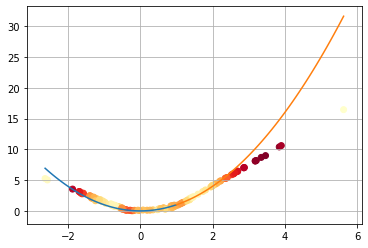

In [60]:
N = 128
V = generator.predict(TestData.load_random(n_samples=N))
Plot('test').picture(V, discriminator.model.predict(V), alpha=1)